In [1]:
import pandas as pd
import cbsodata

# tables = cbsodata.get_table_list()
# for table in tables:
#     if "home" in table["Title"]:
#         print(f"{table['Identifier']}: {table['Title']}")

data = cbsodata.get_data("85773ENG")

df = pd.DataFrame(data)

print(df.shape)
print(df.describe())
print(df.head())
print(df.tail())
print(df.iloc[0])

(510, 10)
               ID  PriceIndexSellingPrices_1  \
count  510.000000                 510.000000   
mean   254.500000                  75.340196   
std    147.368586                  26.431093   
min      0.000000                  28.800000   
25%    127.250000                  64.800000   
50%    254.500000                  73.300000   
75%    381.750000                  81.700000   
max    509.000000                 144.100000   

       ChangesComparedToThePreviousPeriod_2  \
count                            507.000000   
mean                               0.960552   
std                                2.193816   
min                               -6.300000   
25%                                0.100000   
50%                                0.600000   
75%                                1.200000   
max                               17.800000   

       ChangesComparedToThePreviousYear_3    SoldHomes_4  \
count                          493.000000     510.000000   
mean         

In [2]:
df.columns

Index(['ID', 'Periods', 'PriceIndexSellingPrices_1',
       'ChangesComparedToThePreviousPeriod_2',
       'ChangesComparedToThePreviousYear_3', 'SoldHomes_4',
       'ChangesComparedToThePreviousPeriod_5',
       'ChangesComparedToThePreviousYear_6', 'AveragePurchasePrice_7',
       'TotalValuePurchasePrices_8'],
      dtype='object')

In [8]:
df["Year"] = df.Periods.map(lambda x: x.split(" ")[0])

<Axes: xlabel='Year'>

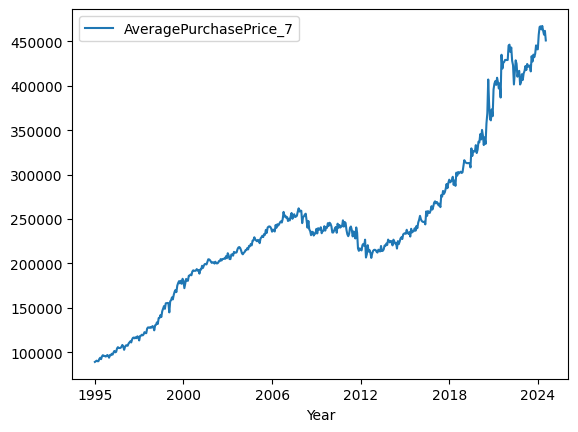

In [10]:
df.plot(x="Year", y="AveragePurchasePrice_7")